In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torchvision.transforms.functional as TF

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Custom Dataset for 5-channel input (RGB + venation + edge)
class LeafMultiChannelDataset(Dataset):
    def __init__(self, rgb_dir, venation_dir, edge_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.venation_dir = venation_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.samples = []

        self.classes = sorted(os.listdir(rgb_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls_name in self.classes:
            cls_folder = os.path.join(rgb_dir, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((cls_name, fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls_name, fname = self.samples[idx]
        label = self.class_to_idx[cls_name]

        rgb_path = os.path.join(self.rgb_dir, cls_name, fname)
        venation_path = os.path.join(self.venation_dir, cls_name, fname)
        edge_path = os.path.join(self.edge_dir, cls_name, fname)

        rgb_image = Image.open(rgb_path).convert('RGB')
        venation_image = Image.open(venation_path).convert('L')
        edge_image = Image.open(edge_path).convert('L')

        if self.transform:
            rgb_image = self.transform(rgb_image)
            venation_tensor = TF.to_tensor(venation_image)
            edge_tensor = TF.to_tensor(edge_image)
        else:
            rgb_image = TF.to_tensor(rgb_image)
            venation_tensor = TF.to_tensor(venation_image)
            edge_tensor = TF.to_tensor(edge_image)

        combined = torch.cat([rgb_image, venation_tensor, edge_tensor], dim=0)
        return combined, label

# Transform for RGB image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset Paths
base_dir = "C:/Users/yasha/OneDrive/Desktop/College work/6th SEM/DL/DL Project/Output"
rgb_dir = os.path.join(base_dir, "rgb")
venation_dir = os.path.join(base_dir, "venation")
edge_dir = os.path.join(base_dir, "edge")

# Load Dataset
dataset = LeafMultiChannelDataset(rgb_dir, venation_dir, edge_dir, transform=transform)
num_classes = len(dataset.classes)

# Split into Train and Validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


# Model Definition
class VenationNet(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3):
        super(VenationNet, self).__init__()

        self.conv1 = self._conv_block(5, 32)   # 5 channels (RGB + venation + edge)
        self.conv2 = self._conv_block(32, 64)
        self.conv3 = self._conv_block(64, 128)
        self.conv4 = self._conv_block(128, 256, dilated=True)
        self.conv5 = self._conv_block(256, 512)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(32 + 64 + 128 + 256 + 512, num_classes)

    def _conv_block(self, in_channels, out_channels, dilated=False):
        dilation = 2 if dilated else 1
        padding = dilation
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        x1_pool = self.global_pool(x1).view(x.size(0), -1)
        x2_pool = self.global_pool(x2).view(x.size(0), -1)
        x3_pool = self.global_pool(x3).view(x.size(0), -1)
        x4_pool = self.global_pool(x4).view(x.size(0), -1)
        x5_pool = self.global_pool(x5).view(x.size(0), -1)

        x_fused = torch.cat([x1_pool, x2_pool, x3_pool, x4_pool, x5_pool], dim=1)
        x_fused = self.dropout(x_fused)
        return self.fc(x_fused)

# Initialize model, criterion, optimizer
model = VenationNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
best_val_acc = 0.0
checkpoint_path = "best_venationnet_multichannel.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Best model saved with val acc: {best_val_acc:.2f}%")

print("🎉 Training Complete! Best model saved at:", checkpoint_path)

# Load and Evaluate Best Model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
print("✅ Best model loaded for final evaluation.")

Epoch 1/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.36it/s, acc=18.6, loss=2.38]


Epoch [1/20] | Train Loss: 2.7776, Train Acc: 18.60% | Val Loss: 3.7860, Val Acc: 11.72%
✅ Best model saved with val acc: 11.72%


Epoch 2/20: 100%|█████████████████████████████████████████████████| 46/46 [00:32<00:00,  1.41it/s, acc=31.2, loss=2.05]


Epoch [2/20] | Train Loss: 2.2763, Train Acc: 31.20% | Val Loss: 2.8381, Val Acc: 23.98%
✅ Best model saved with val acc: 23.98%


Epoch 3/20: 100%|███████████████████████████████████████████████████| 46/46 [00:32<00:00,  1.40it/s, acc=38, loss=1.55]


Epoch [3/20] | Train Loss: 2.0044, Train Acc: 38.01% | Val Loss: 1.8664, Val Acc: 43.60%
✅ Best model saved with val acc: 43.60%


Epoch 4/20: 100%|███████████████████████████████████████████████████| 46/46 [00:32<00:00,  1.42it/s, acc=45, loss=1.82]


Epoch [4/20] | Train Loss: 1.7245, Train Acc: 44.96% | Val Loss: 1.6994, Val Acc: 45.50%
✅ Best model saved with val acc: 45.50%


Epoch 5/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=48.4, loss=1.29]


Epoch [5/20] | Train Loss: 1.6126, Train Acc: 48.43% | Val Loss: 2.1833, Val Acc: 37.87%


Epoch 6/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.39it/s, acc=52.2, loss=1.63]


Epoch [6/20] | Train Loss: 1.4571, Train Acc: 52.25% | Val Loss: 1.5013, Val Acc: 52.04%
✅ Best model saved with val acc: 52.04%


Epoch 7/20: 100%|█████████████████████████████████████████████████| 46/46 [00:32<00:00,  1.40it/s, acc=54.1, loss=1.36]


Epoch [7/20] | Train Loss: 1.4158, Train Acc: 54.09% | Val Loss: 1.8885, Val Acc: 41.42%


Epoch 8/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.36it/s, acc=56.1, loss=1.62]


Epoch [8/20] | Train Loss: 1.3432, Train Acc: 56.06% | Val Loss: 1.6470, Val Acc: 50.68%


Epoch 9/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=60.6, loss=1.15]


Epoch [9/20] | Train Loss: 1.2359, Train Acc: 60.56% | Val Loss: 1.8259, Val Acc: 44.69%


Epoch 10/20: 100%|████████████████████████████████████████████████| 46/46 [00:32<00:00,  1.41it/s, acc=63.4, loss=1.18]


Epoch [10/20] | Train Loss: 1.1462, Train Acc: 63.35% | Val Loss: 1.3956, Val Acc: 53.68%
✅ Best model saved with val acc: 53.68%


Epoch 11/20: 100%|█████████████████████████████████████████████████| 46/46 [00:34<00:00,  1.35it/s, acc=64, loss=0.834]


Epoch [11/20] | Train Loss: 1.0770, Train Acc: 63.96% | Val Loss: 1.4557, Val Acc: 53.41%


Epoch 12/20: 100%|█████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.36it/s, acc=67, loss=0.852]


Epoch [12/20] | Train Loss: 0.9950, Train Acc: 67.03% | Val Loss: 1.3570, Val Acc: 59.40%
✅ Best model saved with val acc: 59.40%


Epoch 13/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.39it/s, acc=72.1, loss=0.873]


Epoch [13/20] | Train Loss: 0.8790, Train Acc: 72.07% | Val Loss: 1.0199, Val Acc: 69.48%
✅ Best model saved with val acc: 69.48%


Epoch 14/20: 100%|████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=72.5, loss=1.07]


Epoch [14/20] | Train Loss: 0.8234, Train Acc: 72.48% | Val Loss: 1.2518, Val Acc: 59.95%


Epoch 15/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=75.5, loss=0.973]


Epoch [15/20] | Train Loss: 0.7774, Train Acc: 75.54% | Val Loss: 1.0737, Val Acc: 67.57%


Epoch 16/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.38it/s, acc=77.7, loss=0.662]


Epoch [16/20] | Train Loss: 0.7120, Train Acc: 77.72% | Val Loss: 0.8491, Val Acc: 73.02%
✅ Best model saved with val acc: 73.02%


Epoch 17/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=80.1, loss=0.849]


Epoch [17/20] | Train Loss: 0.6335, Train Acc: 80.11% | Val Loss: 1.1289, Val Acc: 65.94%


Epoch 18/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.38it/s, acc=81.5, loss=0.551]


Epoch [18/20] | Train Loss: 0.6112, Train Acc: 81.54% | Val Loss: 1.0694, Val Acc: 67.30%


Epoch 19/20: 100%|███████████████████████████████████████████████| 46/46 [00:33<00:00,  1.37it/s, acc=81.4, loss=0.541]


Epoch [19/20] | Train Loss: 0.5783, Train Acc: 81.40% | Val Loss: 0.8782, Val Acc: 70.30%


Epoch 20/20: 100%|████████████████████████████████████████████████| 46/46 [00:33<00:00,  1.38it/s, acc=83.9, loss=0.38]


Epoch [20/20] | Train Loss: 0.5143, Train Acc: 83.92% | Val Loss: 0.9512, Val Acc: 70.30%
🎉 Training Complete! Best model saved at: best_venationnet_multichannel.pth
✅ Best model loaded for final evaluation.


C:\Users\yasha\AppData\Local\Temp\ipykernel_24604\2238008208.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [4]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Classification Report
report = classification_report(all_labels, all_preds, target_names=dataset.classes, zero_division=0)

# Print results
print(f"\n✅ Final Evaluation Metrics on Validation Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}, Weighted Recall: {recall_weighted:.4f}, Weighted F1 Score: {f1_weighted:.4f}")
print("\nPer-class Precision, Recall, and F1:")
for i, cls in enumerate(dataset.classes):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


✅ Final Evaluation Metrics on Validation Set:
Accuracy: 71.39%
Macro Precision: 0.7531, Macro Recall: 0.7252, Macro F1 Score: 0.7000
Weighted Precision: 0.7838, Weighted Recall: 0.7139, Weighted F1 Score: 0.7096

Per-class Precision, Recall, and F1:
Alpinia Galanga (Rasna): Precision: 0.6000, Recall: 0.5000, F1 Score: 0.5455
Amaranthus Viridis (Arive-Dantu): Precision: 0.8235, Recall: 0.6364, F1 Score: 0.7179
Artocarpus Heterophyllus (Jackfruit): Precision: 0.8571, Recall: 0.8000, F1 Score: 0.8276
Azadirachta Indica (Neem): Precision: 0.5000, Recall: 0.9091, F1 Score: 0.6452
Basella Alba (Basale): Precision: 1.0000, Recall: 0.5385, F1 Score: 0.7000
Brassica Juncea (Indian Mustard): Precision: 0.5714, Recall: 1.0000, F1 Score: 0.7273
Carissa Carandas (Karanda): Precision: 0.9286, Recall: 0.9286, F1 Score: 0.9286
Citrus Limon (Lemon): Precision: 0.6667, Recall: 0.3636, F1 Score: 0.4706
Ficus Auriculata (Roxburgh fig): Precision: 0.5000, Recall: 0.8000, F1 Score: 0.6154
Ficus Religiosa (

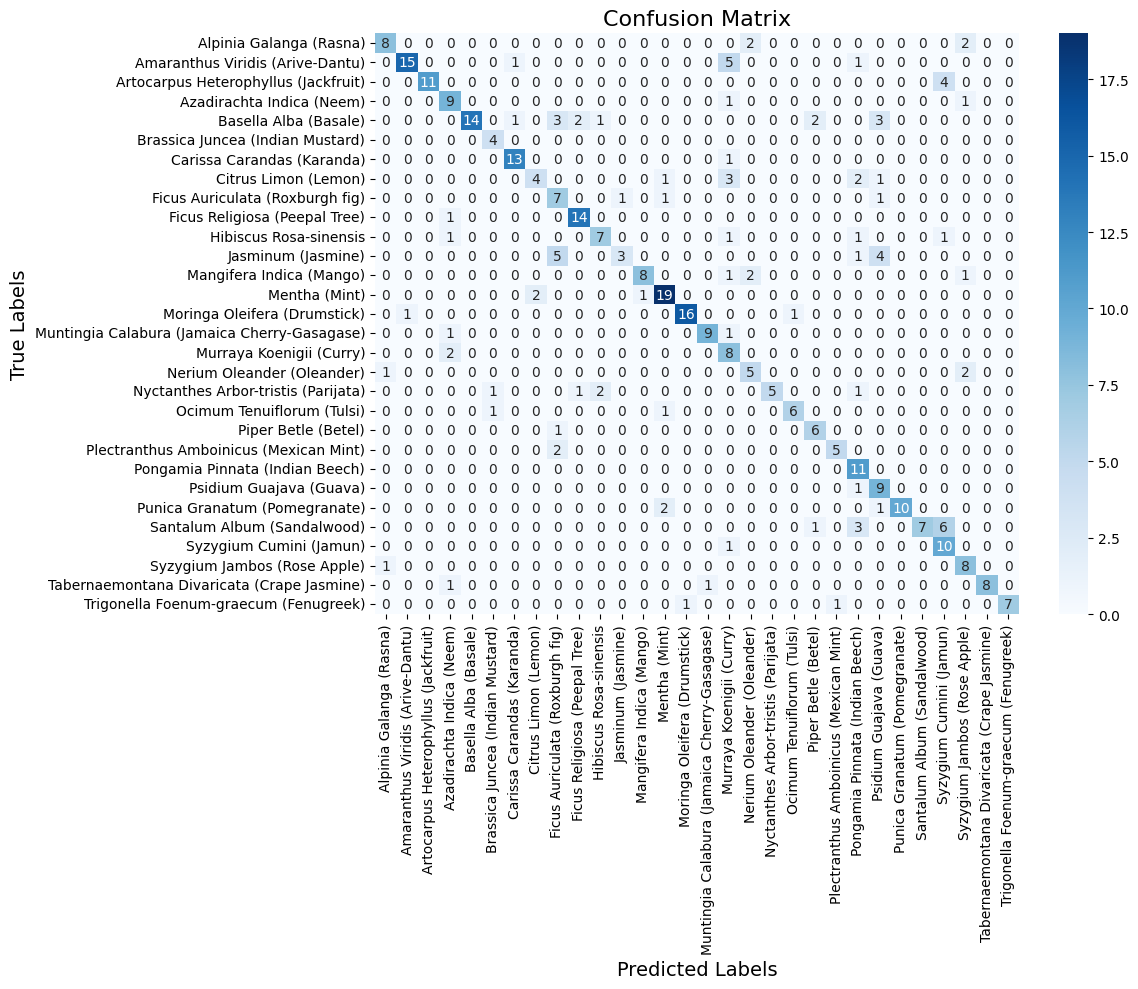


📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.8000    0.6667    0.7273        12
            Amaranthus Viridis (Arive-Dantu)     0.9375    0.6818    0.7895        22
        Artocarpus Heterophyllus (Jackfruit)     1.0000    0.7333    0.8462        15
                   Azadirachta Indica (Neem)     0.6000    0.8182    0.6923        11
                       Basella Alba (Basale)     1.0000    0.5385    0.7000        26
            Brassica Juncea (Indian Mustard)     0.6667    1.0000    0.8000         4
                  Carissa Carandas (Karanda)     0.8667    0.9286    0.8966        14
                        Citrus Limon (Lemon)     0.6667    0.3636    0.4706        11
             Ficus Auriculata (Roxburgh fig)     0.3889    0.7000    0.5000        10
               Ficus Religiosa (Peepal Tree)     0.8235    0.9333    0.8750        15
                      Hibi

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # list of class names

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=1000)
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=False)
print("\n📊 Classification Report:\n")
print(report)

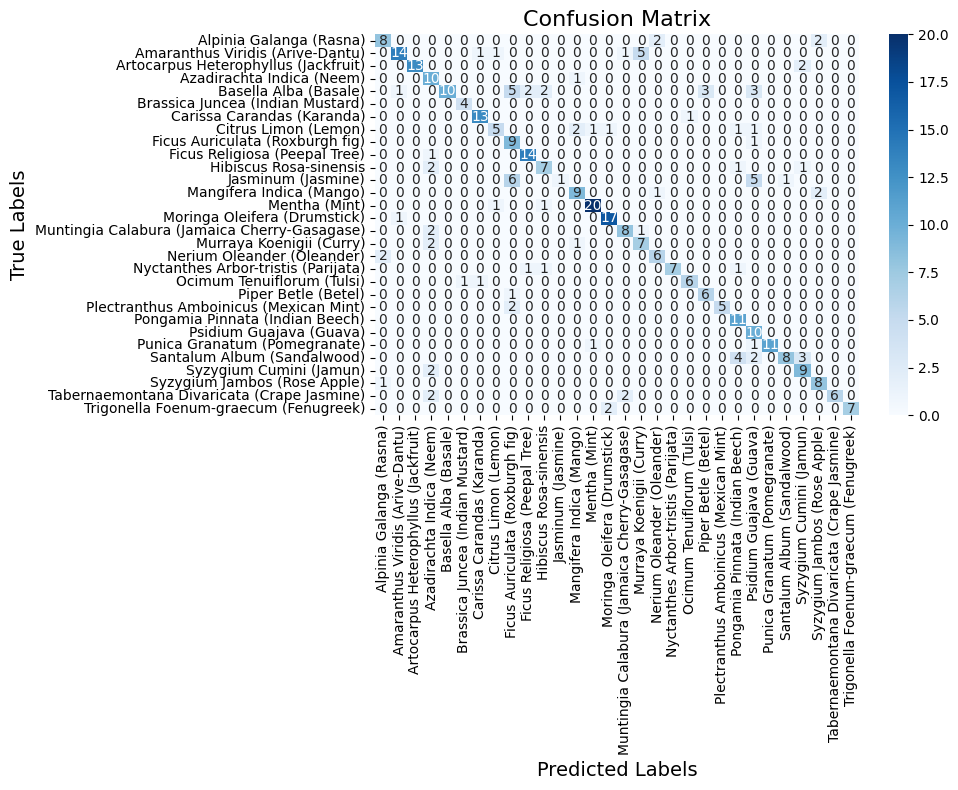

In [6]:
# Plot confusion matrix heatmap with better label formatting
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))  # Increase size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Make sure x-axis labels are horizontal and not colliding
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=1000)
plt.show()